# Blood vessel detection using UNET

First we divide images into adequate folders, segmenting train and test images to 128x128 windows:

In [2]:
from skimage.util import view_as_windows
from random import sample
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import cv2
import shutil 
import os
import glob

TRAIN_IMG_DIR = 'data/train_images'
VAL_IMG_DIR = 'data/val_images'
TEST_IMG_DIR = 'data/test_images'

TRAIN_MASK_DIR = 'data/train_masks'
VAL_MASK_DIR = 'data/val_masks'
TEST_MASK_DIR = 'data/test_masks'

IMAGE_SIZE =  64

def create_folders():
    if not os.path.exists(TRAIN_IMG_DIR):
        os.makedirs(TRAIN_IMG_DIR)

    if not os.path.exists(VAL_IMG_DIR):
        os.makedirs(VAL_IMG_DIR)

    if not os.path.exists(TEST_IMG_DIR):
        os.makedirs(TEST_IMG_DIR)

    if not os.path.exists(TRAIN_MASK_DIR):
        os.makedirs(TRAIN_MASK_DIR)

    if not os.path.exists(VAL_MASK_DIR):
        os.makedirs(VAL_MASK_DIR)

    if not os.path.exists(TEST_MASK_DIR):
        os.makedirs(TEST_MASK_DIR)
        
def create_dataset(num_samples):
    create_folders()
    
    img_filenames = glob.glob("data/images/*")
    img_filenames.sort()
    images = [cv2.imread(img) for img in img_filenames]

    mask_filenames = glob.glob("data/manual1/*")
    mask_filenames.sort()
    masks = [cv2.imread(img, 0) for img in mask_filenames]

    # copy test images to test folder
    for i, (img_path, mask_path) in enumerate(zip(img_filenames[:5], mask_filenames[:5])):
        shutil.copy(img_path, TEST_IMG_DIR + "/" + str(i) + ".png")
        shutil.copy(mask_path, TEST_MASK_DIR + "/" + str(i) + ".png")

    # create windows for train and val images
    all_windows = []
    all_mask_windows = []
    for img, mask in zip(images[5:], masks[5:]):
        windows = view_as_windows(img, (IMAGE_SIZE, IMAGE_SIZE, 3), step=IMAGE_SIZE)
        width, height, _, _, _, _ = windows.shape
        windows = windows.flatten().reshape(width*height, IMAGE_SIZE, IMAGE_SIZE, 3)
        all_windows.extend(windows)

        mask_windows = view_as_windows(mask, (IMAGE_SIZE, IMAGE_SIZE), step=IMAGE_SIZE)
        mask_windows = mask_windows.flatten().reshape(width*height, IMAGE_SIZE, IMAGE_SIZE)
        all_mask_windows.extend(mask_windows)
    
    # sample created data
    data = list(zip(all_windows, all_mask_windows))
    after_sampling = sample(data, num_samples)
    all_windows, all_mask_windows = zip(*after_sampling)

    for i, (window, mask_window) in enumerate(zip(all_windows, all_mask_windows)):
        if i <= len(all_windows) * 0.8: # add to train set
            cv2.imwrite(TRAIN_IMG_DIR + "/" + str(i) + ".png", window)
            cv2.imwrite(TRAIN_MASK_DIR + "/" + str(i) + ".tiff", mask_window)
        else: # add to val set
            cv2.imwrite(VAL_IMG_DIR + "/" + str(i) + ".png", window)
            cv2.imwrite(VAL_MASK_DIR + "/" + str(i) + ".tiff", mask_window)
            
#create_dataset(500)

Next we define UNET architecture:

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

Then we create dataset

In [4]:
from torch.utils.data import Dataset

class BloodVesselDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = glob.glob(image_dir + "/*")
        self.images.sort()
        self.masks = glob.glob(mask_dir + "/*")
        self.masks.sort()
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = self.images[index]
        mask_path = self.masks[index]
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, 0)
        mask = mask/255
        
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        
        return image, mask

In [159]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

# HYPERPARAMETERS
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 20
NUM_WORKERS = 0
PIN_MEMORY = True
LOAD_MODEL = True


def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.float().to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)
        
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # update tqdm loop
        loop.set_postfix(loss=loss.item())

        
train_transform = A.Compose(
[
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
#     A.Rotate(limit=35, p=1.0),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.1),
    ToTensorV2()
])

val_transform = A.Compose(
[
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    ToTensorV2()
])


In [165]:
import torchvision
from torch.utils.data import DataLoader

def save_checkpoint(state, filename):
    print("===>Saving checkpoint")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model):
    print("===>Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    
def get_loaders(
        train_dir,
        train_mask_dir,
        val_dir,
        val_mask_dir,
        batch_size,
        train_transform,
        val_transform,
        num_workers=4,
        pin_memory=True):
    
    train_ds = BloodVesselDataset(
        image_dir=train_dir,
        mask_dir=train_mask_dir,
        transform=train_transform)
    
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True)
    
    val_ds = BloodVesselDataset(
        image_dir=val_dir,
        mask_dir=val_mask_dir,
        transform=val_transform)
    
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False)
    
    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.float().to(device)
            y = y.float().to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(
    loader, model, epoch, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.float().to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(x.float(), f"{folder}img_{epoch}_{idx}.png")
        torchvision.utils.save_image(
            preds, f"{folder}pred_{epoch}_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1).float(), f"{folder}mask_{epoch}_{idx}.png")

    model.train()

In [166]:
if __name__ == '__main__':
    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transform,
        NUM_WORKERS,
        PIN_MEMORY
    )

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train(train_loader, model, optimizer, loss_fn, scaler)
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }
        save_checkpoint(checkpoint, filename=f"checkpoint_{epoch}")
        check_accuracy(val_loader, model, device=DEVICE)
        save_predictions_as_imgs(val_loader, model, epoch, device=DEVICE)

100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:14<00:00,  5.16s/it, loss=0.606]


===>Saving checkpoint
Got 354767/405504 with acc 87.49
Dice score: 0.2291875034570694


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:19<00:00,  5.36s/it, loss=0.487]


===>Saving checkpoint
Got 355973/405504 with acc 87.79
Dice score: 0.33228057622909546


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:19<00:00,  5.38s/it, loss=0.417]


===>Saving checkpoint
Got 380679/405504 with acc 93.88
Dice score: 0.3538402020931244


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:28<00:00,  5.70s/it, loss=0.424]


===>Saving checkpoint
Got 364175/405504 with acc 89.81
Dice score: 0.4141623079776764


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:30<00:00,  5.77s/it, loss=0.715]


===>Saving checkpoint
Got 384434/405504 with acc 94.80
Dice score: 0.4586260914802551


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:31<00:00,  5.84s/it, loss=0.396]


===>Saving checkpoint
Got 387490/405504 with acc 95.56
Dice score: 0.5272369980812073


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:27<00:00,  5.68s/it, loss=0.573]


===>Saving checkpoint
Got 388422/405504 with acc 95.79
Dice score: 0.504065752029419


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:19<00:00,  5.36s/it, loss=0.494]


===>Saving checkpoint
Got 388267/405504 with acc 95.75
Dice score: 0.4941989481449127


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:19<00:00,  5.36s/it, loss=0.329]


===>Saving checkpoint
Got 390073/405504 with acc 96.19
Dice score: 0.5633763074874878


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:30<00:00,  5.81s/it, loss=0.373]


===>Saving checkpoint
Got 389211/405504 with acc 95.98
Dice score: 0.523614227771759


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:33<00:00,  5.90s/it, loss=0.382]


===>Saving checkpoint
Got 390595/405504 with acc 96.32
Dice score: 0.5654832124710083


100%|███████████████████████████████████████████████████████████████████████| 26/26 [02:24<00:00,  5.56s/it, loss=0.34]


===>Saving checkpoint
Got 389222/405504 with acc 95.98
Dice score: 0.5429099202156067


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:20<00:00,  5.39s/it, loss=0.284]


===>Saving checkpoint
Got 391715/405504 with acc 96.60
Dice score: 0.5926217436790466


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:27<00:00,  5.65s/it, loss=0.283]


===>Saving checkpoint
Got 391163/405504 with acc 96.46
Dice score: 0.5717266798019409


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:21<00:00,  5.42s/it, loss=0.243]


===>Saving checkpoint
Got 391876/405504 with acc 96.64
Dice score: 0.5951409935951233


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:22<00:00,  5.50s/it, loss=0.281]


===>Saving checkpoint
Got 391217/405504 with acc 96.48
Dice score: 0.5766009092330933


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:33<00:00,  5.89s/it, loss=0.271]


===>Saving checkpoint
Got 390719/405504 with acc 96.35
Dice score: 0.5506109595298767


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:22<00:00,  5.50s/it, loss=0.367]


===>Saving checkpoint
Got 388792/405504 with acc 95.88
Dice score: 0.5028867125511169


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:21<00:00,  5.44s/it, loss=0.242]


===>Saving checkpoint
Got 389202/405504 with acc 95.98
Dice score: 0.5415995121002197


100%|██████████████████████████████████████████████████████████████████████| 26/26 [02:32<00:00,  5.85s/it, loss=0.365]


===>Saving checkpoint
Got 389683/405504 with acc 96.10
Dice score: 0.5239031910896301


Code for creating test dataset

In [ ]:
test_img_filenames = glob.glob("data/images/*")
test_img_filenames.sort()
test_images = [cv2.imread(img) for img in test_img_filenames][:5]


test_mask_filenames = glob.glob("data/manual1/*")
test_mask_filenames.sort()
test_masks = [cv2.imread(img, 0) for img in test_mask_filenames][:5]

for idx, (img, mask) in enumerate(zip(test_images, test_masks)):
    windows = view_as_windows(img, (IMAGE_SIZE, IMAGE_SIZE, 3), step=IMAGE_SIZE)
    width, height, _, _, _, _ = windows.shape
    windows = windows.flatten().reshape(width*height, IMAGE_SIZE, IMAGE_SIZE, 3)

    mask_windows = view_as_windows(mask, (IMAGE_SIZE, IMAGE_SIZE), step=IMAGE_SIZE)
    mask_windows = mask_windows.flatten().reshape(width*height, IMAGE_SIZE, IMAGE_SIZE)
    
    for i, (window, mask_window) in enumerate(zip(windows, mask_windows)):
        cv2.imwrite(TEST_IMG_DIR + "/" + str(idx) + "/" + str(i) + ".png", window)
        cv2.imwrite(TEST_MASK_DIR + "/" + str(idx) + "/" + str(i) + ".png", mask_window)

In [168]:
torch.save(model.state_dict(), "model.pt")

In [207]:
def test(model, idx):
    test_img_filenames = sorted(glob.glob("data/test_images/" + str(idx) + "/*.png"), key=os.path.getmtime)
    test_images = [cv2.imread(img) for img in test_img_filenames]
    test_images = np.array(test_images).reshape(1944, 64, 64, 3)
    
    model.eval()
    
    all_preds = []
    for img in tqdm(test_images):
        img_tensor = torch.from_numpy(np.array([img]))
        x = img_tensor.permute(0, 3, 1, 2).float().to(DEVICE)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        all_preds.append(preds[0][0].cpu().detach().numpy())
        
    return all_preds

In [251]:
#predictions = test(model, 0)
    
predictions = np.array(predictions).reshape(36, 54, 64, 64)
image = np.zeros((1, 3456))
for i, row in enumerate(predictions):
    window = np.zeros((64, 3456))
    for j, img in enumerate(row):
        for k, img_row in enumerate(img):
            window[k][j*64: j*64 + 64] = img_row
    image = np.append(image, window, 0)

(_, threshed_predict) = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)

test_img_filenames = sorted(glob.glob("data/test_masks/0/*.png"), key=os.path.getmtime)
test_images = [cv2.imread(img, 0) for img in test_img_filenames]
test_images = np.array(test_images).reshape(36, 54, 64, 64)

image_true = np.zeros((1, 3456))
for i, row in enumerate(test_images):
    window = np.zeros((64, 3456))
    for j, img in enumerate(row):
        for k, img_row in enumerate(img):
            window[k][j*64: j*64 + 64] = img_row
    image_true = np.append(image_true, window, 0)

image_true = image_true[:2305]/255
(_, threshed_predict_true) = cv2.threshold(image_true, 0, 1, cv2.THRESH_BINARY)

print(classification_report(image_true.flatten(), image.flatten()))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98   7556419
         1.0       0.74      0.49      0.59    409661

    accuracy                           0.97   7966080
   macro avg       0.86      0.74      0.79   7966080
weighted avg       0.96      0.97      0.96   7966080



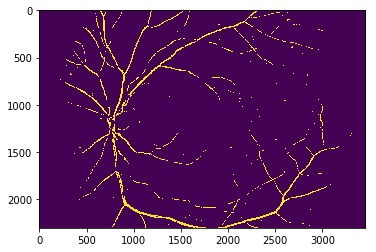

In [252]:
plt.imshow(threshed_predict)
plt.savefig("nn1_predicted.png", dpi=200)

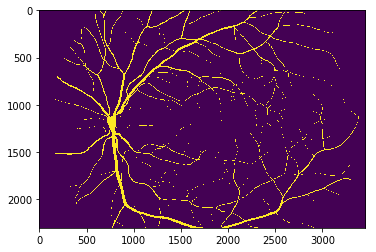

In [253]:
plt.imshow(threshed_predict_true)
plt.savefig("nn1_mask.png", dpi=200)

In [254]:
predictions2 = test(model, 1)
    
predictions2 = np.array(predictions2).reshape(36, 54, 64, 64)
image = np.zeros((1, 3456))
for i, row in enumerate(predictions2):
    window = np.zeros((64, 3456))
    for j, img in enumerate(row):
        for k, img_row in enumerate(img):
            window[k][j*64: j*64 + 64] = img_row
    image = np.append(image, window, 0)

(_, threshed_predict) = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)

test_img_filenames = sorted(glob.glob("data/test_masks/1/*.png"), key=os.path.getmtime)
test_images = [cv2.imread(img, 0) for img in test_img_filenames]
test_images = np.array(test_images).reshape(36, 54, 64, 64)

image_true = np.zeros((1, 3456))
for i, row in enumerate(test_images):
    window = np.zeros((64, 3456))
    for j, img in enumerate(row):
        for k, img_row in enumerate(img):
            window[k][j*64: j*64 + 64] = img_row
    image_true = np.append(image_true, window, 0)

image_true = image_true[:2305]/255
(_, threshed_predict_true) = cv2.threshold(image_true, 0, 1, cv2.THRESH_BINARY)

print(classification_report(image_true.flatten(), image.flatten()))

100%|██████████████████████████████████████████████████████████████████████████████| 1944/1944 [05:37<00:00,  5.77it/s]


              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98   7421375
         1.0       0.82      0.49      0.62    544705

    accuracy                           0.96   7966080
   macro avg       0.89      0.74      0.80   7966080
weighted avg       0.95      0.96      0.95   7966080



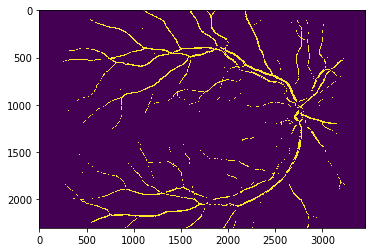

In [255]:
plt.imshow(threshed_predict)
plt.savefig("nn2_predicted.png", dpi=200)

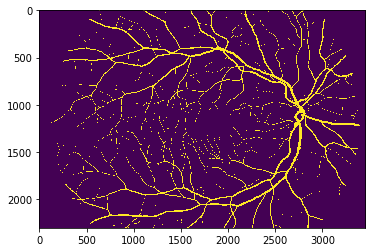

In [256]:
plt.imshow(threshed_predict_true)
plt.savefig("nn2_mask.png", dpi=200)

In [257]:
predictions3 = test(model, 2)
    
predictions3 = np.array(predictions3).reshape(36, 54, 64, 64)
image = np.zeros((1, 3456))
for i, row in enumerate(predictions3):
    window = np.zeros((64, 3456))
    for j, img in enumerate(row):
        for k, img_row in enumerate(img):
            window[k][j*64: j*64 + 64] = img_row
    image = np.append(image, window, 0)

(_, threshed_predict) = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)

test_img_filenames = sorted(glob.glob("data/test_masks/2/*.png"), key=os.path.getmtime)
test_images = [cv2.imread(img, 0) for img in test_img_filenames]
test_images = np.array(test_images).reshape(36, 54, 64, 64)

image_true = np.zeros((1, 3456))
for i, row in enumerate(test_images):
    window = np.zeros((64, 3456))
    for j, img in enumerate(row):
        for k, img_row in enumerate(img):
            window[k][j*64: j*64 + 64] = img_row
    image_true = np.append(image_true, window, 0)

image_true = image_true[:2305]/255
(_, threshed_predict_true) = cv2.threshold(image_true, 0, 1, cv2.THRESH_BINARY)

print(classification_report(image_true.flatten(), image.flatten()))

100%|██████████████████████████████████████████████████████████████████████████████| 1944/1944 [05:46<00:00,  5.61it/s]


              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97   7141638
         1.0       0.94      0.54      0.69    824442

    accuracy                           0.95   7966080
   macro avg       0.94      0.77      0.83   7966080
weighted avg       0.95      0.95      0.94   7966080



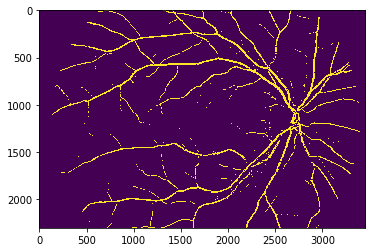

In [258]:
plt.imshow(threshed_predict)
plt.savefig("nn3_predicted.png", dpi=200)

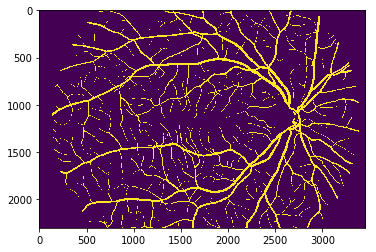

In [259]:
plt.imshow(threshed_predict_true)
plt.savefig("nn3_mask.png", dpi=200)

In [260]:
predictions4 = test(model, 3)
    
predictions4 = np.array(predictions4).reshape(36, 54, 64, 64)
image = np.zeros((1, 3456))
for i, row in enumerate(predictions4):
    window = np.zeros((64, 3456))
    for j, img in enumerate(row):
        for k, img_row in enumerate(img):
            window[k][j*64: j*64 + 64] = img_row
    image = np.append(image, window, 0)

(_, threshed_predict) = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)

test_img_filenames = sorted(glob.glob("data/test_masks/3/*.png"), key=os.path.getmtime)
test_images = [cv2.imread(img, 0) for img in test_img_filenames]
test_images = np.array(test_images).reshape(36, 54, 64, 64)

image_true = np.zeros((1, 3456))
for i, row in enumerate(test_images):
    window = np.zeros((64, 3456))
    for j, img in enumerate(row):
        for k, img_row in enumerate(img):
            window[k][j*64: j*64 + 64] = img_row
    image_true = np.append(image_true, window, 0)

image_true = image_true[:2305]/255
(_, threshed_predict_true) = cv2.threshold(image_true, 0, 1, cv2.THRESH_BINARY)

print(classification_report(image_true.flatten(), image.flatten()))

100%|██████████████████████████████████████████████████████████████████████████████| 1944/1944 [05:32<00:00,  5.84it/s]


              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98   7451062
         1.0       0.76      0.51      0.61    515018

    accuracy                           0.96   7966080
   macro avg       0.86      0.75      0.79   7966080
weighted avg       0.95      0.96      0.95   7966080



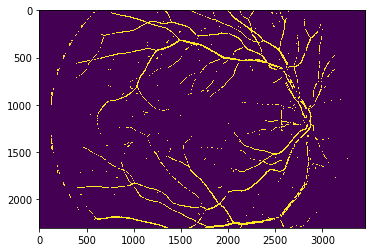

In [261]:
plt.imshow(threshed_predict)
plt.savefig("nn4_predicted.png", dpi=200)

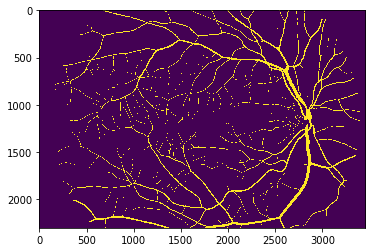

In [262]:
plt.imshow(threshed_predict_true)
plt.savefig("nn4_mask.png", dpi=200)

In [263]:
predictions5 = test(model, 4)
    
predictions5 = np.array(predictions5).reshape(36, 54, 64, 64)
image = np.zeros((1, 3456))
for i, row in enumerate(predictions5):
    window = np.zeros((64, 3456))
    for j, img in enumerate(row):
        for k, img_row in enumerate(img):
            window[k][j*64: j*64 + 64] = img_row
    image = np.append(image, window, 0)

(_, threshed_predict) = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)

test_img_filenames = sorted(glob.glob("data/test_masks/4/*.png"), key=os.path.getmtime)
test_images = [cv2.imread(img, 0) for img in test_img_filenames]
test_images = np.array(test_images).reshape(36, 54, 64, 64)

image_true = np.zeros((1, 3456))
for i, row in enumerate(test_images):
    window = np.zeros((64, 3456))
    for j, img in enumerate(row):
        for k, img_row in enumerate(img):
            window[k][j*64: j*64 + 64] = img_row
    image_true = np.append(image_true, window, 0)

image_true = image_true[:2305]/255
(_, threshed_predict_true) = cv2.threshold(image_true, 0, 1, cv2.THRESH_BINARY)

print(classification_report(image_true.flatten(), image.flatten()))

100%|██████████████████████████████████████████████████████████████████████████████| 1944/1944 [05:33<00:00,  5.83it/s]


              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98   7361830
         1.0       0.86      0.54      0.66    604250

    accuracy                           0.96   7966080
   macro avg       0.91      0.77      0.82   7966080
weighted avg       0.96      0.96      0.95   7966080



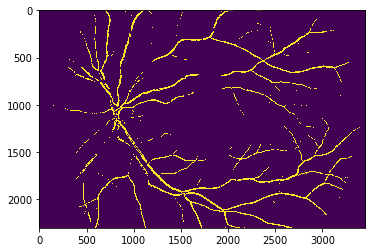

In [264]:
plt.imshow(threshed_predict)
plt.savefig("nn5_predicted.png", dpi=200)

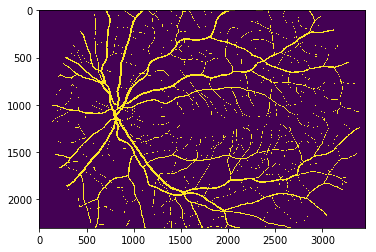

In [265]:
plt.imshow(threshed_predict_true)
plt.savefig("nn5_mask.png", dpi=200)

## Bibliography:
https://www.youtube.com/watch?v=IHq1t7NxS8k&ab_channel=AladdinPersson